In [1]:
using Flux
using Flux: onehot, onehotbatch, crossentropy, reset!, throttle

In [2]:
corpora = Dict()

for file in readdir("data/corpus")
  lang = Symbol(match(r"(.*)\.txt", file).captures[1])
  corpus = split(String(read("data/corpus/$file")), ".")
  corpus = strip.(normalize_string.(corpus, casefold=true, stripmark=true))
  corpus = filter(!isempty, corpus)
  corpora[lang] = corpus
end

corpora

Dict{Any,Any} with 5 entries:
  :en => String["wikipedia (/ˌwɪkɪˈpiːdiə/ ( listen)wik-i-pee-dee-ə or /ˌwɪkiˈp…
  :it => String["wikipedia (pronuncia: vedi sotto) e un'enciclopediaonline a co…
  :fr => String["wikipedia ecouter est un projet d'encyclopedie universelle, mu…
  :es => String["wikipedia es una enciclopedialibre,[nota 2]\u200bpoliglota y e…
  :da => String["wikipedia er en encyklopædi med abent indhold, skrevet i samar…

In [5]:
langs = collect(keys(corpora))

5-element Array{Any,1}:
 :en
 :it
 :fr
 :es
 :da

In [6]:
alphabet = ['a':'z'; '0':'9'; ' '; '\n'; '_'];

In [7]:
# See which chars will be represented as "unknown"
unique(filter(x -> x ∉ alphabet, join(vcat(values(corpora)...))))

148-element Array{Char,1}:
 '('
 '/'
 'ˌ'
 'ɪ'
 'ˈ'
 'ː'
 'ə'
 ' '
 ')'
 '-'
 '['
 ']'
 ','
 ⋮  
 'ব'
 'ল'
 'দ'
 'শ'
 'চ'
 'ট'
 'ম'
 'ঢ'
 'ক'
 'খ'
 'হ'
 'স'

In [8]:
dataset = [(onehotbatch(s, alphabet, '_'), onehot(l, langs))
           for l in langs for s in corpora[l]] |> shuffle
        

8284-element Array{Tuple{Flux.OneHotMatrix{Array{Flux.OneHotVector,1}},Flux.OneHotVector},1}:
 (Bool[false false … false false; false false … false false; … ; false false … false false; false false … false false], Bool[false, true, false, false, false])
 (Bool[false true … false false; false false … false false; … ; false false … false false; false false … false false], Bool[false, true, false, false, false]) 
 (Bool[false false … true false; false false … false false; … ; false false … false false; true false … false false], Bool[false, false, false, true, false])  
 (Bool[false false … false true; false false … false false; … ; false false … false false; true false … false false], Bool[false, false, false, true, false])  
 (Bool[false false … false false; false false … false false; … ; false false … false false; true false … false false], Bool[true, false, false, false, false]) 
 (Bool[false false … false false; false false … false false; … ; false false … false false; true false … f

In [9]:
train, test = dataset[1:end-100], dataset[end-99:end];

In [10]:
N = 15

scanner = Chain(Dense(length(alphabet), N, σ), LSTM(N, N))
encoder = Dense(N, length(langs))

function model(x)
  state = scanner.(x.data)[end]
  reset!(scanner)
  softmax(encoder(state))
end

loss(x, y) = crossentropy(model(x), y)

loss (generic function with 1 method)

In [11]:
testloss() = mean(loss(t...) for t in test)
opt = ADAM(params(scanner, encoder))
evalcb = () -> @show testloss()

(::#11) (generic function with 1 method)

In [ ]:
Flux.train!(loss, train, opt, cb = throttle(evalcb, 10));

In [14]:
model(onehotbatch(normalize_string("c'é una bella filosofia", casefold=true, stripmark=true),
        alphabet, '_'))

Tracked 5-element Array{Float64,1}:
 0.143299 
 0.165127 
 0.0809996
 0.524173 
 0.0864007

In [15]:
using Interact, Plots

In [16]:
predict(s) =
    isempty(s) ?
        softmax(ones(length(langs))) :
        model(onehotbatch(normalize_string(s, casefold=true, stripmark=true), alphabet, '_')).data

predict (generic function with 1 method)

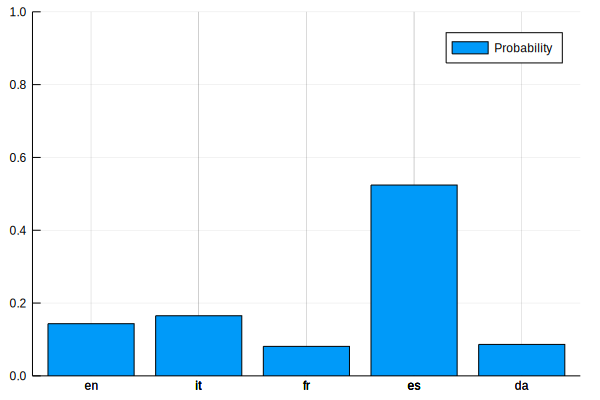

In [17]:
@manipulate for s = "c'é una bella filosofia"
    bar(String.(langs), predict(s),
        label=["Probability"], ylims=(0,1))
end